### Introduction

> In statistics, Bayesian linear regression is an approach to linear regression in which the statistical analysis is undertaken within the context of Bayesian inference. When the regression model has errors that have a normal distribution, and if a particular form of prior distribution is assumed, explicit results are available for the posterior probability distributions of the model's parameters.

**Linear Regression**


In simple linear regression we get point estimates by,
$$ y = \alpha\ + \beta\ *x $$
 Equation says, there's a linear relationship between variable $x$ and $y$. Slope is controlled by $ \beta\ $ and intercept tells about value of $y$ when $x=0$ . Methods like Ordinary Least Squares, optimize the parameters to minimize the error between observed $y$ and predicted $y$. These methods only return single best value for parameters.
  
** Bayesian Approach: **
 
 The same problem can be stated under probablistic framework. We can obtain best values of $ \alpha\ $  and $ \beta\ $ along with their uncertainity estimations. Probablistically linear regression can be explained as : 
 
$$ y \sim N(\mu=\alpha+\beta x, \sigma=\varepsilon) $$

$y$ is observed as a Gaussian distribution with mean $ \mu\ $ and standard deviation $ \sigma\ $. Unlike OLS regression, here it is normally distibuted. Since we do not know the values of $ \alpha\ $  , $ \beta\ $ and $ \epsilon\ $, we have to set prior distributions for them. 

$$ \begin{array}{l}{\alpha \sim N\left(\mu_{\alpha}, \sigma_{\alpha}\right)} \\ {\beta \sim N\left(\mu_{\beta}, \sigma_{\beta}\right)} \\ {\varepsilon \sim U\left(0, h_{s}\right)}\end{array}$$




In this post, I'm going to demonstrate very simple linear regression problem with both OLS and bayesian approach. We will use [PyMC3 package](https://docs.pymc.io/). PyMC3 is a Python package for Bayesian statistical modeling and probabilistic machine learning.

###Import basic modules

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


### Generate linear artificial data

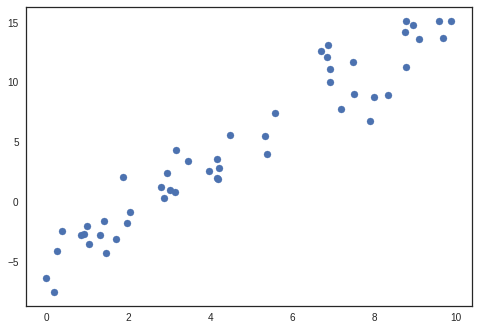

In [22]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + 2*rng.randn(50)
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

plt.scatter(x, y)

### Create PyMC3 model

In [23]:
import pymc3 as pm
print('Running on the PyMC3 v{}'.format(pm.__version__))
basic_model =  pm.Model()

Running on the PyMC3 v3.6


### Define model parameters

Context is created for defining model parameters using `with` statement. Using context makes it easy to assign parameters to model.

Distributions for  $ \alpha\ $  , $ \beta\ $ and $ \epsilon\ $ are defined. $ \mu\ $ is a deterministic variable which calculated using line equation.

`Ylikelihood` is a likelihood parameter which is defined ny Normal distribution with $ \mu\ $ and $ \sigma\ $. Observed values are also passed along with distribution.

In [0]:
with basic_model as bm:

    #Priors
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=1)

    # Deterministics
    mu = alpha + beta*x
    
    # Likelihood 
    Ylikelihood = pm.Normal('Ylikelihood', mu=mu, sd=sigma, observed=y)

### Sampling from posterior

As model is defined completely, now we can sample from posterior. PyMC3 automatically chooses appropriate model depending on the type of data. In our case of continuous data, NUTS is used.

In [25]:
 trace = pm.sample(draws=2000,model=bm)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]
100%|██████████| 2500/2500 [00:03<00:00, 721.84it/s]
The acceptance probability does not match the target. It is 0.8850329863869828, but should be close to 0.8. Try to increase the number of tuning steps.


### Trace summary and plots
Traceplots plots samples histograms and values.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f62726495f8>,
      dtype=object)

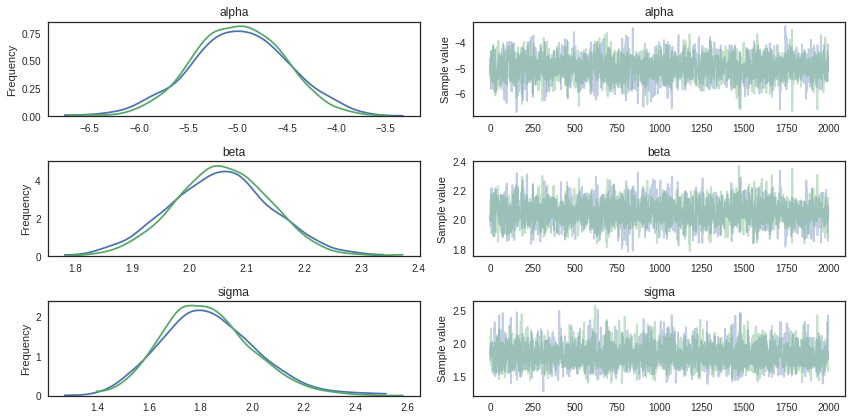

In [26]:
pm.traceplot(trace)

In [27]:
print(pm.summary(trace).round(2))

       mean    sd  mc_error  hpd_2.5  hpd_97.5    n_eff  Rhat
alpha -5.00  0.48      0.01    -5.93     -4.05  1619.65   1.0
beta   2.05  0.09      0.00     1.89      2.23  1583.34   1.0
sigma  1.83  0.18      0.00     1.49      2.18  2254.55   1.0


### Checking autocorrelation

Bar plot of the autocorrelation function for a trace can be plotted using [pymc3.plots.autocorrplot](https://docs.pymc.io/api/plots.html).

Autocorrelation dictates the amount of time you have to wait for convergence. If autocorrelation is high, you will have to use a longer burn-in. Low autocorrelation means good exploration.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f62727094e0>,
      dtype=object)

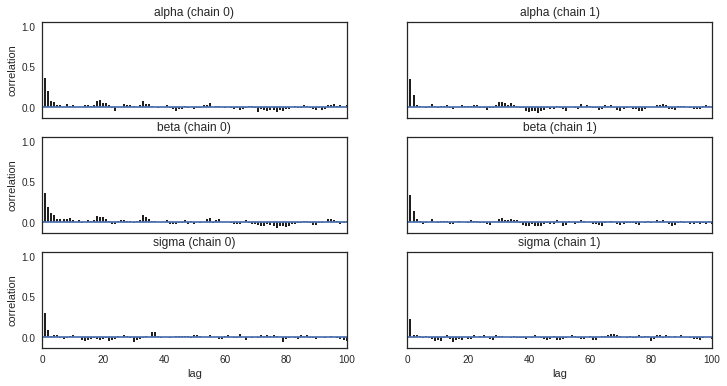

In [28]:
pm.autocorrplot(trace)

### Comparing parameters with Simple Linear Regression (OLS)

Parameters can be cross checked using Simple Linear Regression.

No handles with labels found to put in legend.


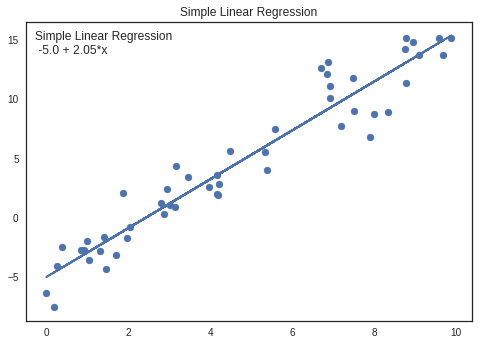

In [29]:

from sklearn.linear_model import LinearRegression
lm = LinearRegression()
ypred =  lm.fit(x,y).predict(x)
plt.scatter(x,y)
plt.plot(x,ypred)
legend_title = 'Simple Linear Regression\n {} + {}*x'.format(round(lm.intercept_[0],2),round(lm.coef_[0][0],2))
legend = plt.legend(loc='upper left', frameon=False, title=legend_title)
plt.title("Simple Linear Regression")
plt.show()


Parameters are almost similar for both pyMc3 and Simple Linear Regression

**Intercept:  **

OLS: -5.0
PyMc3: -5.0

**Coefficient: **

OLS: 2.03
PyMc3: 2.05

###Plotting traces



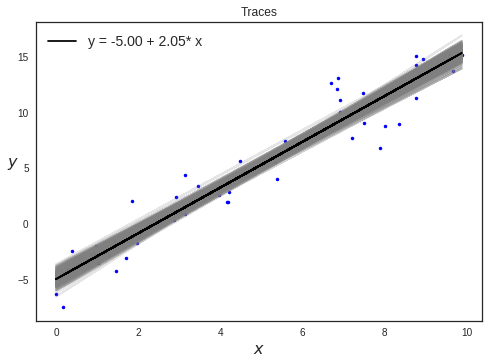

In [30]:
plt.plot(x, y, 'b.');

idx = range(0, len(trace['alpha']), 10)
alpha_m = trace['alpha'].mean()
beta_m = trace['beta'].mean()

plt.plot(x, trace['alpha'][idx] + trace['beta'][idx] *x, c='gray', alpha=0.2);
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f}* x'.format(alpha_m, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)
plt.title("Traces")
plt.show()

### Posterior Plots
Plot Posterior densities in style of John K. Kruschke's book.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6271803828>,
      dtype=object)

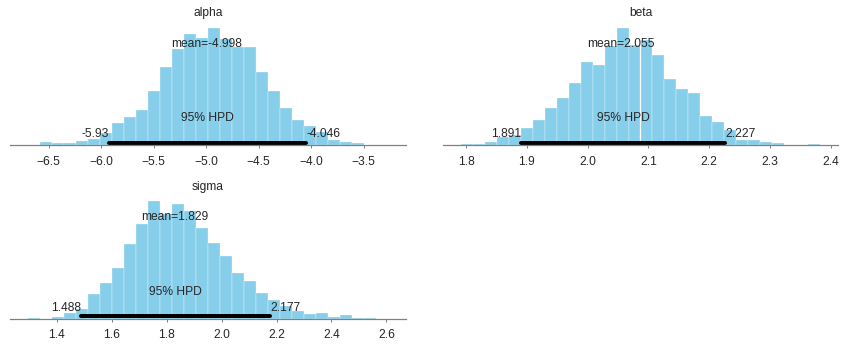

In [31]:
pm.plots.plot_posterior(trace)

### Forest Plots
Generates a “forest plot” of 100*(1-alpha)% credible intervals from a trace or list of traces.

GridSpec(1, 2, width_ratios=[3, 1])

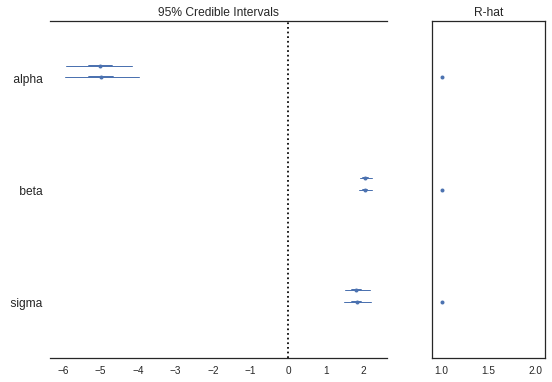

In [32]:
pm.plots.forestplot(trace)

### Plotting energy distributions
Plot energy transition distribution and marginal energy distribution in order to diagnose poor exploration by HMC algorithms.

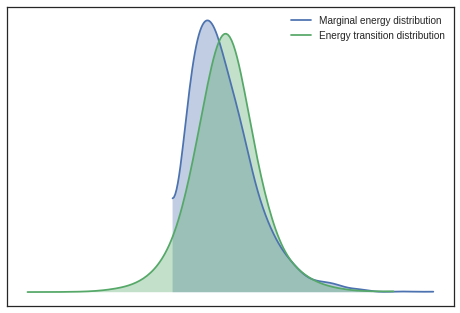

In [33]:
pm.plots.energyplot(trace)

### Density Plots
Generates KDE plots for continuous variables. Plots are truncated at their 100*(1-alpha)% credible intervals.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f62723b6da0>,
      dtype=object)

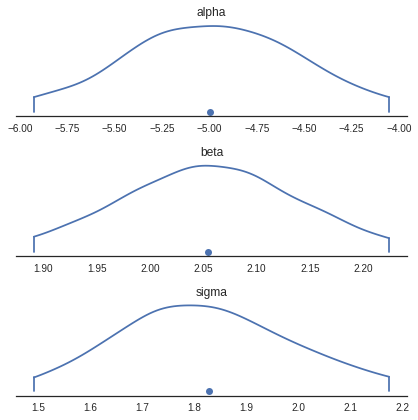

In [34]:
pm.plots.densityplot(trace)

### Sampling from Posterior

Posterior predictive checks (PPCs) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior.

We will draw samples from the observed model.

In [35]:
ypred = pm.sampling.sample_posterior_predictive(model=bm,trace=trace, samples=500)
y_sample_posterior_predictive = np.asarray(ypred['Ylikelihood'])

100%|██████████| 500/500 [00:00<00:00, 1090.41it/s]


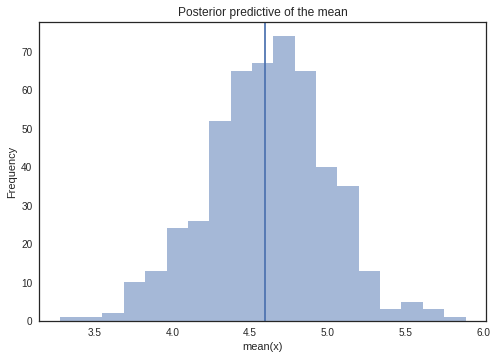

In [36]:
_, ax = plt.subplots()
ax.hist([n.mean() for n in y_sample_posterior_predictive], bins=19, alpha=0.5)
ax.axvline(y.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

### Plotting HPD intervals

We can plot credible intervals to see unobserved parameter values that fall with a particular subjective probability. The HPD has the nice property that any point **within** the interval has a higher density than any other point outside. To calculate highest posterior density (HPD) of array for given alpha, we use a function given by PyMC3 :  [pymc3.stats.hpd()](https://docs.pymc.io/api/stats.html)

In [0]:
sig0 = pm.hpd(y_sample_posterior_predictive, alpha=0.5)
sig1 = pm.hpd(y_sample_posterior_predictive, alpha=0.05)

#removing extra dimension
sig0 = np.squeeze(sig0)
sig1 = np.squeeze(sig1)

#Reshaping and sorting
inds = x.ravel().argsort()    
x_ord = x.ravel()[inds].reshape(-1)

y= y[inds]
sig0ord= sig0[inds]
sig1ord = sig1[inds]

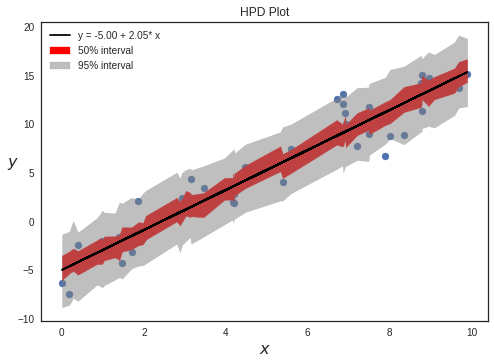

In [38]:

pal = sns.color_palette('Purples')
#plt.plot(x, y, 'b.')
plt.scatter(x_ord,y)
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f}* x'.format(alpha_m, beta_m))
plt.fill_between(x_ord, sig0ord[:,0], sig0ord[:,1], color='red',alpha=1,label="50% interval")
plt.fill_between(x_ord, sig1ord[:,0], sig1ord[:,1], color='gray',alpha=0.5,label="95% interval")
plt.legend()
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.title("HPD Plot")
plt.show()

Similarily using 'posterior_predictive' samples, we can get various percentile values to plot.

In [0]:
dfp = np.percentile(y_sample_posterior_predictive,[2.5,25,50,70,97.5],axis=0)
dfp = np.squeeze(dfp)
dfp = dfp[:,inds]

ymean = y_sample_posterior_predictive.mean(axis=0)
ymean =ymean[inds]

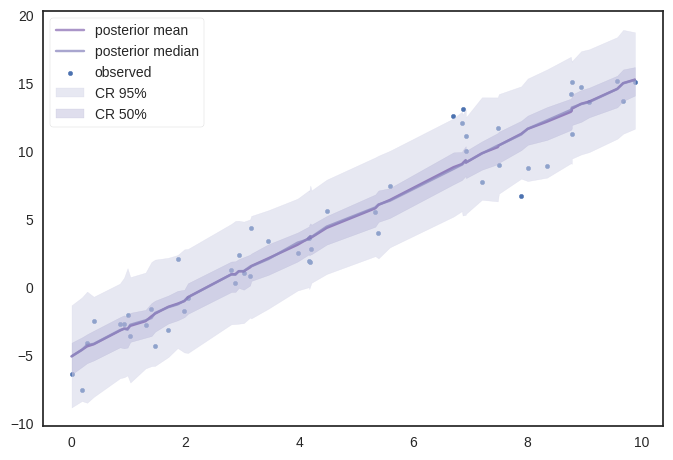

In [40]:

pal = sns.color_palette('Purples')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["axes.linewidth"]  = 1.25
plt.rcParams["axes.edgecolor"] = "0.15"


fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
plt.scatter(x_ord,y,s=10,label='observed')
ax.plot(x_ord,ymean,c=pal[5],label='posterior mean',alpha=0.5)
ax.plot(x_ord,dfp[2,:],alpha=0.75,color=pal[3],label='posterior median')
ax.fill_between(x_ord,dfp[0,:],dfp[4,:],alpha=0.5,color=pal[1],label='CR 95%')
ax.fill_between(x_ord,dfp[1,:],dfp[3,:],alpha=0.4,color=pal[2],label='CR 50%')
ax.legend()
plt.legend(frameon=True)
plt.show()


### Source

You can find jupyter notebook [here]()